# Audio Classification the from-scratch way

Thanks to the SF Study Group practitioners: @aamir7117, @marii, @simonjhb, @ste, @ThomM, @zachcaceres.

We're going to demonstrate the technique of classifying audio samples by first converting the audio into spectrograms, then treating the spectrograms as images. Once we've converted the spectrograms to images, the workflow is just the same as using imagenette or any other image classification task.

What do we need to do?
* Download the data
* Load the data 
* Transform the data into spectrograms
* Load the audio data into a databunch such that we can use our previously-defined `learner` object

### Setup & imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_12c import *

import torchaudio
from torchaudio import transforms

In [3]:
#export
AUDIO_EXTS = {str.lower(k) for k,v in mimetypes.types_map.items() if v.startswith('audio/')}

### Download

There's some BS here because the target .tgz file doesn't extract itself to its own directory. Bad hygiene!

I also can't remember why we're allowed to use the datasets.untar_data function, but that's what the other notebooks are using, so ¯\\\_(ツ)_/¯

In [4]:
dsid = "ST-AEDS-20180100_1-OS"
data_url = f'http://www.openslr.org/resources/45/{dsid}' # actual URL has .tgz extension but untar_data doesn't like that
path = Path.home() / Path(f".fastai/data/{dsid}/")
datasets.untar_data(data_url, dest=path)
# path = path.parent

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [5]:
path

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

## Loading into an AudioList

Getting a file list the `08_data_block` way.

The "manual" way using `get_files`…

In [6]:
wavs = get_files(path, extensions=AUDIO_EXTS)
print(f"Found {len(wavs)} audio files")
wavs[:5]

Found 3842 audio files


[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00068.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00192.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00356.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00355.wav')]

…But that's not very exciting. Let's make an `AudioList`, so we can use transforms, and define how to `get` an Audio.

### AudioList

In [7]:
#export
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = AUDIO_EXTS
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): 
        sig, sr = torchaudio.load(fn)
        assert sig.size(0) == 1, "Non-mono audio detected, mono only supported for now."
        return (sig.squeeze(), sr) ## .squeeze() assumes mono audio. TODO: support stereo.

In [8]:
al = AudioList.from_files(path); al

AudioList (3842 items)
[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00068.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00192.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00356.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00355.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00134.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00311.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00019.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00005.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00250.wav')...]
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS

It looks like this is full of file paths, but that's just the `repr` talking. Actually accessing an item from the list calls the `get` method and returns a `(Tensor, Int)` tuple representing the signal & sample rate.

In [9]:
al[0]

(tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -6.1035e-05,
          0.0000e+00, -3.3569e-04]), 16000)

## Splitting into train/validation

Our data is all in one folder, there's no specific validation set, so let's just split it at random.

In [10]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))

In [11]:
sd

SplitData
Train: AudioList (3052 items)
[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00192.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00356.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00355.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00134.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00005.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00250.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00318.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00390.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00430.wav')...]
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS
Valid: AudioList (790

## Labeling

Our labels are encoded in our filenames. For example, `m0003_us_m0003_00032.wav` has the label `m0003`. Let's make a regex labeler, then use it.

In [12]:
#export
def re_labeler(fn, pat): return re.findall(pat, str(fn))[0]

In [13]:
label_pat = r'/([mf]\d+)_'
speaker_labeler = partial(re_labeler, pat=label_pat)
ll = label_by_func(sd, speaker_labeler, proc_y=CategoryProcessor())

In [14]:
ll

SplitData
Train: LabeledData
x: AudioList (3052 items)
[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00192.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00356.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00355.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00134.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00005.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00250.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00318.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00390.wav'), PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00430.wav')...]
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS
y: Ite

## Transforms: audio clipping & conversion to spectrograms

The tensors we're going to pass to the pytorch dataloader need to be all of the same size, but our input audio files are of different sizes, so we need to trim them. Also, recall that we're not going to send the model the _audio_ directly; we're going to convert it to spectrograms first. We can treat these steps as transforms. In particular, the `_order` property makes this simple.

### PadOrTrim

In [15]:
#export
class PadOrTrim(Transform):
    _order=10
    def __init__(self,msecs):
        self.msecs = msecs
        
    def __call__(self, ad, trim_section="mid", pad_at_end=True): 
        sig, sr = ad
        mx = sr//1000 * self.msecs
        siglen = len(sig)
        if siglen < mx:
            diff = mx - siglen
            padding = sig.new_zeros(diff) # Maintain input tensor device & type params
            nsig = torch.cat((sig,padding)) if pad_at_end else torch.cat((padding,sig))
        else:
            if trim_section not in {"start","mid","end"}: 
                raise ValueError(f"'trim_section' argument must be one of 'start', 'mid' or 'end', got '{trim_section}'")
            if trim_section == "mid":
                nsig = sig.narrow(0, (siglen // 2) - (mx // 2), mx)
            elif trim_section == "end":
                nsig = sig.narrow(0, siglen-mx, mx)
            else:
                nsig = sig.narrow(0, 0, mx)
        return (nsig, sr)

Small helper to show some audio.

In [16]:
#export
from IPython.display import Audio
def show_audio(ad):
    sig,sr=ad
    return Audio(data=sig, rate=sr)

*Note - this won't work if you've already run the notebook all the way through, because `ll` now contains Tensors representing Spectrograms, not `(Signal, SampleRate)` tuples.*

In [17]:
show_audio(ll.train[0][0])

In [18]:
pt = PadOrTrim(3000)
show_audio(pt(ll.train[0][0]))

### Spectrogram

Luckily, `torchaudio` takes care of the calculation & conversion to Spectrograms for us.

Instead of clipping our audio, we could also modify our spectrogram transform to ensure all the final spectrograms had the same shape, but that's a little more complicated, as the size of the spectrograms is a function of the length of the clip; so we'd have to calculate a `n_mels` and/or `ws` (window_size) param independently per clip.

In [19]:
#export
class Spectrogrammer(Transform):
    _order=90
    def __init__(self, to_db_scale=True, n_fft=400, ws=None, hop=None, 
                 f_min=0.0, f_max=None, pad=0, n_mels=128, top_db=None):
        self.to_db_scale, self.n_fft, self.ws, self.hop, self.f_min, self.f_max, \
        self.pad, self.n_mels, self.top_db = to_db_scale, n_fft, ws, hop, f_min, \
        f_max, pad, n_mels, top_db

    def __call__(self, ad):
        sig,sr = ad
        meller = transforms.MelSpectrogram(sr, self.n_fft, self.ws, self.hop, self.f_min, 
                                           self.f_max, self.pad, self.n_mels)
        mels = meller(sig.unsqueeze(0))
        mels = mels.permute(0,2,1)
        if self.to_db_scale:
            return transforms.SpectrogramToDB(top_db=self.top_db)(mels)
        return mels

In [20]:
speccer = Spectrogrammer(n_fft=1024, n_mels=64, top_db=80)

Small helper to show a spectrogram.

In [21]:
#export
def show_spectro(img, ax=None, figsize=(6,6), withShape=True):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img if (img.shape[0]==3) else img.squeeze(0))
    if withShape: display(f'Tensor shape={img.shape}')

*Note - this won't work if you've already run the notebook all the way through, because `ll` now contains Tensors representing Spectrograms, not `(Signal, SampleRate)` tuples.*

'Tensor shape=torch.Size([1, 64, 169])'

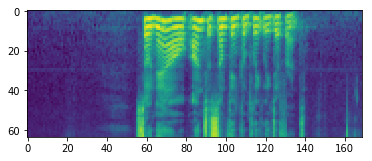

In [22]:
show_spectro(speccer(ll.train[0][0]))

Now let's create the transforms with the params we want, and rebuild our label lists using them. 

Note that now the items in the final `LabelList` won't be tuples anymore, they'll just be tensors. This is convenient for actually using the data, but it means you can't really go back and listen to your audio anymore. We can probably find a way around this, but let's press on for now.

### Using the transforms

In [23]:
pad_3sec = PadOrTrim(3000)
speccer = Spectrogrammer(n_fft=1024, n_mels=64, top_db=80)

tfms = [pad_3sec, speccer]

al = AudioList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, speaker_labeler, proc_y=CategoryProcessor())

'Tensor shape=torch.Size([1, 64, 94])'

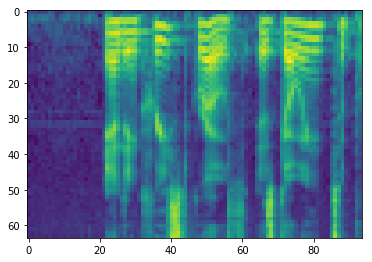

In [24]:
show_spectro(ll.train[83][0])

## Databunch

Now we've got our beautifully transformed tensors, let's add them into a databunch, so we can feed a model easily.

We can use our `get_dls` func which we defined in `03_minibatch_training`, but let's use the to_databunch func we defined in `08_data_block` instead, it's much nicer.

In [25]:
bs=64

c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))

In [26]:
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [27]:
x,y = next(iter(data.train_dl))

'Tensor shape=torch.Size([1, 64, 94])'

'f0001'

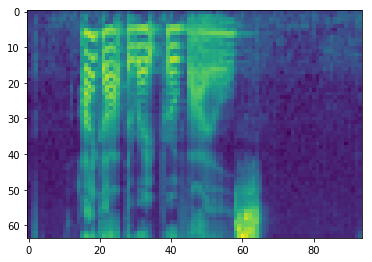

In [28]:
i = randint(0,bs)
show_spectro(x[i])
ll.train.proc_y.vocab[y[i]]

## Training

Go for gold! As a proof of concept, let's use the *pièce de résistance* model & hyperparameters from Lesson 11 `11_train_imagenette`.

In [29]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr), 
            ParamScheduler('mom', sched_mom)]

In [30]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func)

In [31]:
learn.fit(5, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.002702,0.840645,2.014823,0.597035,00:10
1,0.678235,0.967742,1.032972,0.796496,00:09
2,0.614829,0.982581,0.644966,0.974393,00:09
3,0.555338,0.996774,0.564667,0.990566,00:09
4,0.527549,1.000000,0.528454,0.998652,00:09


## Demo - all at once

This is all the code it takes to do it end-to-end (not counting the `#export` cells above).

In [32]:
# dsid = "ST-AEDS-20180100_1-OS"
# data_url = f'http://www.openslr.org/resources/45/{dsid}' # actual URL has .tgz extension but untar_data doesn't like that
# path = Path.home() / Path(f".fastai/data/{dsid}/")
# datasets.untar_data(data_url, dest=path)

# pad_3sec = PadOrTrim(3000)
# speccer = Spectrogrammer(n_fft=1024, n_mels=64, top_db=80)

# tfms = [pad_3sec, speccer]

# al = AudioList.from_files(path, tfms=tfms)

# sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))

# label_pat = r'/([mf]\d+)_'
# speaker_labeler = partial(re_labeler, pat=label_pat)
# ll = label_by_func(sd, speaker_labeler, proc_y=CategoryProcessor())

# bs=64
# c_in = ll.train[0][0].shape[0]
# c_out = len(uniqueify(ll.train.y))

# data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

# opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
# loss_func = LabelSmoothingCrossEntropy()
# lr = 1e-2
# pct_start = 0.5
# phases = create_phases(pct_start)
# sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
# sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
# cbscheds = [ParamScheduler('lr', sched_lr), 
#             ParamScheduler('mom', sched_mom)]

# learn = cnn_learner(xresnet34, data, loss_func, opt_func)
# learn.fit(5, cbs=cbscheds)

## Fin

In [33]:
nb_auto_export()

<IPython.core.display.Javascript object>